# Import

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import math
import itertools
import logging
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

**seed 고정**

In [2]:
import os
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(0)

**Arguments**

In [3]:
argparser = ArgumentParser()
argparser.add_argument("--num_flows", default=3, type=int)
argparser.add_argument("--flow", default="RealNVP", type=str)
argparser.add_argument("--iterations", default=500, type=int)
argparser.add_argument("--data", default="moon", type=str)

args = argparser.parse_args([])
args

Namespace(data='moon', flow='RealNVP', iterations=500, num_flows=3)

# data gen

In [4]:
def gen_data(args):
    '''
    Generates multi-modal(3) gaussian distribution in 2-dimensional space.
    
    or
    
    Generates Make_moons dataset 
    
    args:
        n : The number of samples
    '''
    if args.data=='moon':
        return make_moons(100)[0]
    
    else:
        np.random.seed(0)
        return np.concatenate((np.random.randn(512 // 3, 2) + np.array([0, 7]), # (170,2)
                               np.random.randn(512 // 3, 2) + np.array([2.5, 3]), # (170,2)
                               np.random.randn(512 // 3, 2) + np.array([-2.5, 3])), axis=0) # (170,2)


def plot_data(x, figsize, **kwargs):
    plt.figure(figsize=figsize)
    plt.scatter(x[:,0], x[:,1], marker="o", **kwargs)
    plt.style.use("ggplot")

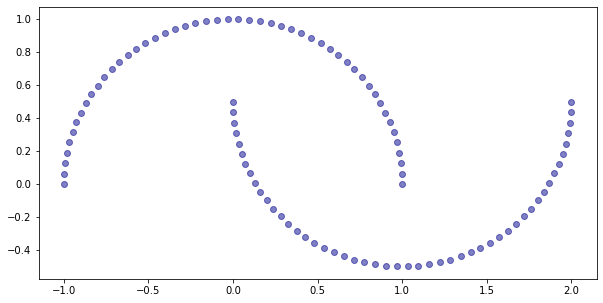

In [5]:
x = torch.Tensor(gen_data(args))

plot_data(x, figsize=(10,5), color='darkblue', alpha=0.5)

# Define models

- reference : https://github.com/tonyduan/normalizing-flows/

```python

def forward(self, x):
        ...
        
    return z, log_det


def inverse(self, z):
        ...
        
    return x, log_det

```

- FCNN : Fully Connected layer
    - linear-A-linear-A-linear
    
- Planar : simple transformation(2015), no inverse
<img src="imgs/planar.png" width="250" height="50">
   
    
- RealNVP(2017)
    - Affine transform(partitioned)
    
- OneByOneConv(Glow, 2018)
    - Affine transform(partitioned) + 1x1 conv

In [6]:
# non-linear function의 derivative를 직접 저장

functional_derivatives = {
    torch.tanh: lambda x: 1 - torch.pow(torch.tanh(x), 2),
    F.leaky_relu: lambda x: (x > 0).type(torch.FloatTensor) + \
                            (x < 0).type(torch.FloatTensor) * -0.01,
    F.elu: lambda x: (x > 0).type(torch.FloatTensor) + \
                     (x < 0).type(torch.FloatTensor) * torch.exp(x)
}

In [7]:
class FCNN(nn.Module):
    """
    Simple fully connected neural network.
    """
    def __init__(self, in_dim, out_dim, hidden_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.network(x)

In [8]:
class Planar(nn.Module):
    """
    Planar flow.
        z = f(x) = x + u h(wᵀx + b)
    [Rezende and Mohamed, 2015]
    
    params : u, w, b
    fucntion : h
    """
    def __init__(self, dim, nonlinearity=torch.tanh):
        super().__init__()
        self.h = nonlinearity
        self.w = nn.Parameter(torch.Tensor(dim))
        self.u = nn.Parameter(torch.Tensor(dim))
        self.b = nn.Parameter(torch.Tensor(1))
        self.reset_parameters(dim)

    def reset_parameters(self, dim):
        init.uniform_(self.w, -math.sqrt(1/dim), math.sqrt(1/dim))
        init.uniform_(self.u, -math.sqrt(1/dim), math.sqrt(1/dim))
        init.uniform_(self.b, -math.sqrt(1/dim), math.sqrt(1/dim))

    def forward(self, x):
        """
        Given x, returns z and the log-determinant log|df/dx|.
        Returns
        -------
        """
        lin = (x @ self.w + self.b).unsqueeze(1) 
        z = x + self.u * self.h(lin)
        phi = functional_derivatives[self.h](lin) * self.w
        log_det = torch.log(torch.abs(1 + phi @ self.u))
        
        return z, log_det
    

    def inverse(self, z):
        raise NotImplementedError("Planar flow has no algebraic inverse.")

In [9]:
class RealNVP(nn.Module):
    """
    Non-volume preserving flow.
    [Dinh et. al. 2017]
    """
    def __init__(self, dim, hidden_dim = 8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.t1 = base_network(dim // 2, dim // 2, hidden_dim) # in_dim, out_dim, hidden_dim
        self.s1 = base_network(dim // 2, dim // 2, hidden_dim)
        self.t2 = base_network(dim // 2, dim // 2, hidden_dim)
        self.s2 = base_network(dim // 2, dim // 2, hidden_dim)

    def forward(self, x):
        lower, upper = x[:,:self.dim // 2], x[:,self.dim // 2:]
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = t1_transformed + upper * torch.exp(s1_transformed)
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = t2_transformed + lower * torch.exp(s2_transformed)
        z = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(s1_transformed, dim=1) + \
                  torch.sum(s2_transformed, dim=1)
        return z, log_det

    def inverse(self, z):
        lower, upper = z[:,:self.dim // 2], z[:,self.dim // 2:]
        t2_transformed = self.t2(upper)
        s2_transformed = self.s2(upper)
        lower = (lower - t2_transformed) * torch.exp(-s2_transformed)
        t1_transformed = self.t1(lower)
        s1_transformed = self.s1(lower)
        upper = (upper - t1_transformed) * torch.exp(-s1_transformed)
        x = torch.cat([lower, upper], dim=1)
        log_det = torch.sum(-s1_transformed, dim=1) + \
                  torch.sum(-s2_transformed, dim=1)
        return x, log_det

In [10]:
class OneByOneConv(nn.Module):
    """
    Invertible 1x1 convolution.
    [Kingma and Dhariwal, 2018.]
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        # scipy qr : https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.qr.html
        W, _ = sp.linalg.qr(np.random.randn(dim, dim)) # 행렬의 QR 분해, Random matrix에서 Q(정규직교행렬)로 W를 초기화
        # scipy lu : https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html
        P, L, U = sp.linalg.lu(W) # 행렬의 LU 분해, W matrix의 decomposition. 최종적인 목표는 log_det 연산 효율화
        self.P = torch.tensor(P, dtype = torch.float)
        self.L = nn.Parameter(torch.tensor(L, dtype = torch.float))
        self.S = nn.Parameter(torch.tensor(np.diag(U), dtype = torch.float))
        self.U = nn.Parameter(torch.triu(torch.tensor(U, dtype = torch.float),
                              diagonal = 1))
        self.W_inv = None

    def forward(self, x):
        # 'torch.tril' ref : https://runebook.dev/ko/docs/pytorch/generated/torch.tril
        L = torch.tril(self.L, diagonal = -1) + torch.diag(torch.ones(self.dim))
        U = torch.triu(self.U, diagonal = 1)
        z = x @ self.P @ L @ (U + torch.diag(self.S)) # x @ W
        log_det = torch.sum(torch.log(torch.abs(self.S)))
        return z, log_det

    def inverse(self, z):
        L = torch.tril(self.L, diagonal = -1) + \
            torch.diag(torch.ones(self.dim))
        U = torch.triu(self.U, diagonal = 1)
        W = self.P @ L @ (U + torch.diag(self.S))
        self.W_inv = torch.inverse(W)
        
        x = z @ self.W_inv
        log_det = -torch.sum(torch.log(torch.abs(self.S)))
        return x, log_det
    
    
class ActNorm(nn.Module):
    """
    ActNorm layer.
    [Kingma and Dhariwal, 2018.]
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.mu = nn.Parameter(torch.zeros(dim, dtype = torch.float))
        self.log_sigma = nn.Parameter(torch.zeros(dim, dtype = torch.float))

    def forward(self, x):
        z = x * torch.exp(self.log_sigma) + self.mu # s:log_sigma(scale), b:mu(translation) -> learnable, data-dependent!
        log_det = torch.sum(self.log_sigma)
        return z, log_det

    def inverse(self, z):
        x = (z - self.mu) / torch.exp(self.log_sigma)
        log_det = -torch.sum(self.log_sigma)
        return x, log_det

**python 'eval' function**

In [11]:
print(args.flow)
print(eval(args.flow))

RealNVP
<class '__main__.RealNVP'>


## Set prior
- Multivariate Normal distributions(0,1) in 2 dim

In [12]:
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

## Set transformations

In [13]:
# The number of flow transformation = 10
args.num_flows =10

flows_planar = [eval('Planar')(dim=2) for _ in range(args.num_flows)]
flows_rnvp = [eval(args.flow)(dim=2) for _ in range(args.num_flows)]

convs = [OneByOneConv(dim=2) for _ in range(args.num_flows)]
actnorms = [ActNorm(dim=2) for _ in range(args.num_flows)]
flows_glow = list(itertools.chain(*zip(actnorms, convs, flows_rnvp)))

flows_glow

[ActNorm(),
 OneByOneConv(),
 RealNVP(
   (t1): FCNN(
     (network): Sequential(
       (0): Linear(in_features=1, out_features=8, bias=True)
       (1): Tanh()
       (2): Linear(in_features=8, out_features=8, bias=True)
       (3): Tanh()
       (4): Linear(in_features=8, out_features=1, bias=True)
     )
   )
   (s1): FCNN(
     (network): Sequential(
       (0): Linear(in_features=1, out_features=8, bias=True)
       (1): Tanh()
       (2): Linear(in_features=8, out_features=8, bias=True)
       (3): Tanh()
       (4): Linear(in_features=8, out_features=1, bias=True)
     )
   )
   (t2): FCNN(
     (network): Sequential(
       (0): Linear(in_features=1, out_features=8, bias=True)
       (1): Tanh()
       (2): Linear(in_features=8, out_features=8, bias=True)
       (3): Tanh()
       (4): Linear(in_features=8, out_features=1, bias=True)
     )
   )
   (s2): FCNN(
     (network): Sequential(
       (0): Linear(in_features=1, out_features=8, bias=True)
       (1): Tanh()
       (2)

## Set Forward, inverse, sample

In [14]:
class NormalizingFlowModel(nn.Module):

    def __init__(self, prior, flows):
        super().__init__()
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def inverse(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m)
        for flow in self.flows[::-1]:
            z, ld = flow.inverse(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x, _ = self.inverse(z)
        return x

In [15]:
model_planar = NormalizingFlowModel(prior, flows_planar)
model_rnvp = NormalizingFlowModel(prior, flows_rnvp)
model_glow = NormalizingFlowModel(prior, flows_glow)

model_glow

NormalizingFlowModel(
  (flows): ModuleList(
    (0): ActNorm()
    (1): OneByOneConv()
    (2): RealNVP(
      (t1): FCNN(
        (network): Sequential(
          (0): Linear(in_features=1, out_features=8, bias=True)
          (1): Tanh()
          (2): Linear(in_features=8, out_features=8, bias=True)
          (3): Tanh()
          (4): Linear(in_features=8, out_features=1, bias=True)
        )
      )
      (s1): FCNN(
        (network): Sequential(
          (0): Linear(in_features=1, out_features=8, bias=True)
          (1): Tanh()
          (2): Linear(in_features=8, out_features=8, bias=True)
          (3): Tanh()
          (4): Linear(in_features=8, out_features=1, bias=True)
        )
      )
      (t2): FCNN(
        (network): Sequential(
          (0): Linear(in_features=1, out_features=8, bias=True)
          (1): Tanh()
          (2): Linear(in_features=8, out_features=8, bias=True)
          (3): Tanh()
          (4): Linear(in_features=8, out_features=1, bias=True)
   

## Set optimizer

In [16]:
opt_planar = optim.Adam(model_planar.parameters(), lr=0.005)
opt_rnvp = optim.Adam(model_rnvp.parameters(), lr=0.005)
opt_glow = optim.Adam(model_glow.parameters(), lr=0.005)

# Train

In [17]:
# arguments setting

args.iterations=1000
args.data='normal'

x = torch.Tensor(gen_data(args))

In [18]:
# normalization
for i in range(x.shape[1]):
    x[:,i] = (x[:,i] - torch.mean(x[:,i])) / torch.std(x[:,i])

In [19]:
def train(args, model, optim, vis=False):
    
    loss_list = []
    
    for i in range(args.iterations):
        optim.zero_grad()
        z, prior_logprob, log_det = model(x)
        logprob = prior_logprob + log_det
        loss = -torch.mean(prior_logprob + log_det)
        loss.backward()
        optim.step()
        
        loss_list.append(float(loss))
        
        if i % 200 == 0:
            print(f"Iter: {i}\t" +
                  f"Logprob: {logprob.mean().data:.2f}\t" +
                  f"Prior: {prior_logprob.mean().data:.2f}\t" +
                  f"LogDet: {log_det.mean().data:.2f}")
    
    figsize=(10,7)

    plt.subplot(1, 3, 1)
    plt.title("Training data")
    plt.scatter(x[:,0], x[:,1], marker="o", color="black", alpha=0.5)

    plt.subplot(1, 3, 2)
    plt.title("Latent space")
    plt.scatter(z.data[:,0], z.data[:,1], marker="o", color="darkblue", alpha=0.5)

    if vis:
        plt.subplot(1, 3, 3)
        plt.title("Generated samples")
        samples = model.sample(500).data
        plt.scatter(samples[:,0], samples[:,1], marker="o", color="black", alpha=0.5)

    plt.show()

    return model, optim, loss_list

## planar

Iter: 0	Logprob: -3.44	Prior: -2.73	LogDet: -0.70
Iter: 200	Logprob: -2.37	Prior: -2.77	LogDet: 0.39
Iter: 400	Logprob: -2.33	Prior: -2.80	LogDet: 0.47
Iter: 600	Logprob: -2.32	Prior: -2.82	LogDet: 0.50
Iter: 800	Logprob: -2.29	Prior: -2.82	LogDet: 0.53


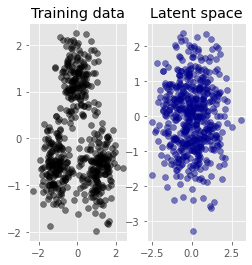

In [20]:
model_planar, opt_planar, loss_planar = train(args, model_planar, opt_planar, vis=False)

## RealNVP

Iter: 0	Logprob: -4.54	Prior: -2.81	LogDet: -1.73
Iter: 200	Logprob: -2.26	Prior: -2.84	LogDet: 0.58
Iter: 400	Logprob: -2.22	Prior: -2.82	LogDet: 0.59
Iter: 600	Logprob: -2.30	Prior: -2.82	LogDet: 0.52
Iter: 800	Logprob: -2.20	Prior: -2.92	LogDet: 0.72


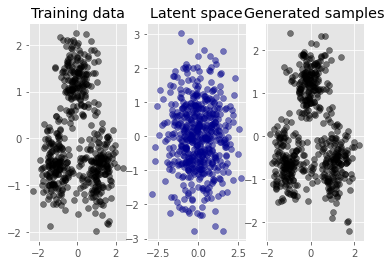

In [21]:
model_rvnp, opt_rvnp, loss_rvnp = train(args, model_rnvp, opt_rnvp, vis=True)

## Glow

Iter: 0	Logprob: -118.19	Prior: -118.93	LogDet: 0.74
Iter: 200	Logprob: -2.43	Prior: -2.82	LogDet: 0.39
Iter: 400	Logprob: -2.32	Prior: -2.84	LogDet: 0.52
Iter: 600	Logprob: -2.29	Prior: -2.84	LogDet: 0.55
Iter: 800	Logprob: -2.26	Prior: -2.84	LogDet: 0.58


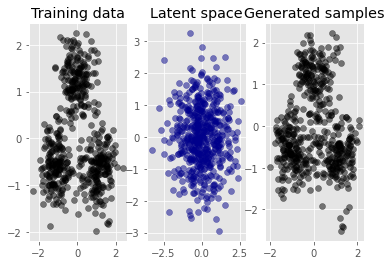

In [22]:
model_glow, opt_glow, loss_glow = train(args, model_glow, opt_glow, vis=True)

## Moon data

In [23]:
# arguments setting
args.data='moon'

x = torch.Tensor(gen_data(args))

In [24]:
# normalization
for i in range(x.shape[1]):
    x[:,i] = (x[:,i] - torch.mean(x[:,i])) / torch.std(x[:,i])

In [25]:
def train(args, model, optim, vis=False):
    
    loss_list = []
    
    for i in range(args.iterations):
        optim.zero_grad()
        z, prior_logprob, log_det = model(x)
        logprob = prior_logprob + log_det
        loss = -torch.mean(prior_logprob + log_det)
        loss.backward()
        optim.step()
        
        loss_list.append(float(loss))
        
        if i % 200 == 0:
            print(f"Iter: {i}\t" +
                  f"Logprob: {logprob.mean().data:.2f}\t" +
                  f"Prior: {prior_logprob.mean().data:.2f}\t" +
                  f"LogDet: {log_det.mean().data:.2f}")
    
    figsize=(10,7)

    plt.subplot(1, 3, 1)
    plt.title("Training data")
    plt.scatter(x[:,0], x[:,1], marker="o", color="black", alpha=0.5)

    plt.subplot(1, 3, 2)
    plt.title("Latent space")
    plt.scatter(z.data[:,0], z.data[:,1], marker="o", color="darkblue", alpha=0.5)

    if vis:
        plt.subplot(1, 3, 3)
        plt.title("Generated samples")
        samples = model.sample(500).data
        plt.scatter(samples[:,0], samples[:,1], marker="o", color="black", alpha=0.5)

    plt.show()

    return model, optim, loss_list

In [26]:
# The number of flow transformation = 10
args.num_flows =10
args.iterations=10000

flows_planar = [eval('Planar')(dim=2) for _ in range(args.num_flows)]
flows_rnvp = [eval(args.flow)(dim=2) for _ in range(args.num_flows)]

convs = [OneByOneConv(dim=2) for _ in range(args.num_flows)]
actnorms = [ActNorm(dim=2) for _ in range(args.num_flows)]
flows_glow = list(itertools.chain(*zip(actnorms, convs, flows_rnvp)))

In [27]:
model_planar = NormalizingFlowModel(prior, flows_planar)
model_rnvp = NormalizingFlowModel(prior, flows_rnvp)
model_glow = NormalizingFlowModel(prior, flows_glow)

In [28]:
opt_planar = optim.Adam(model_planar.parameters(), lr=0.005)
opt_rnvp = optim.Adam(model_rnvp.parameters(), lr=0.005)
opt_glow = optim.Adam(model_glow.parameters(), lr=0.005)

Iter: 0	Logprob: -3.53	Prior: -3.72	LogDet: 0.19
Iter: 200	Logprob: -2.55	Prior: -2.74	LogDet: 0.19
Iter: 400	Logprob: -2.20	Prior: -2.74	LogDet: 0.54
Iter: 600	Logprob: -1.78	Prior: -2.82	LogDet: 1.05
Iter: 800	Logprob: -1.41	Prior: -2.78	LogDet: 1.37
Iter: 1000	Logprob: -0.80	Prior: -2.75	LogDet: 1.95
Iter: 1200	Logprob: -0.42	Prior: -2.78	LogDet: 2.37
Iter: 1400	Logprob: -0.36	Prior: -2.53	LogDet: 2.17
Iter: 1600	Logprob: 0.02	Prior: -2.72	LogDet: 2.74
Iter: 1800	Logprob: 0.21	Prior: -2.69	LogDet: 2.91
Iter: 2000	Logprob: 0.04	Prior: -2.93	LogDet: 2.97
Iter: 2200	Logprob: -0.05	Prior: -2.99	LogDet: 2.95
Iter: 2400	Logprob: -1.17	Prior: -4.00	LogDet: 2.83
Iter: 2600	Logprob: 0.13	Prior: -2.59	LogDet: 2.73
Iter: 2800	Logprob: 0.54	Prior: -2.74	LogDet: 3.28
Iter: 3000	Logprob: -0.04	Prior: -3.26	LogDet: 3.22
Iter: 3200	Logprob: 0.59	Prior: -2.76	LogDet: 3.35
Iter: 3400	Logprob: -0.81	Prior: -3.89	LogDet: 3.08
Iter: 3600	Logprob: 0.46	Prior: -2.75	LogDet: 3.21
Iter: 3800	Logprob: 0.69	P

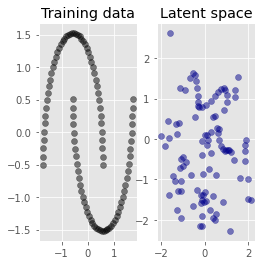

In [29]:
model_planar, opt_planar, loss_planar = train(args, model_planar, opt_planar, vis=False)

Iter: 0	Logprob: -4.42	Prior: -5.06	LogDet: 0.63
Iter: 200	Logprob: -1.36	Prior: -2.94	LogDet: 1.59
Iter: 400	Logprob: -0.71	Prior: -2.84	LogDet: 2.13
Iter: 600	Logprob: -4.09	Prior: -2.44	LogDet: -1.65
Iter: 800	Logprob: -1.65	Prior: -2.92	LogDet: 1.26
Iter: 1000	Logprob: -1.63	Prior: -2.44	LogDet: 0.82
Iter: 1200	Logprob: -0.71	Prior: -2.99	LogDet: 2.27
Iter: 1400	Logprob: -1.18	Prior: -3.28	LogDet: 2.10
Iter: 1600	Logprob: -0.31	Prior: -2.35	LogDet: 2.04
Iter: 1800	Logprob: -0.52	Prior: -3.06	LogDet: 2.54
Iter: 2000	Logprob: -0.89	Prior: -2.45	LogDet: 1.55
Iter: 2200	Logprob: 0.00	Prior: -2.53	LogDet: 2.53
Iter: 2400	Logprob: -0.17	Prior: -2.91	LogDet: 2.74
Iter: 2600	Logprob: -2.98	Prior: -2.67	LogDet: -0.31
Iter: 2800	Logprob: -3.91	Prior: -4.94	LogDet: 1.03
Iter: 3000	Logprob: -1.19	Prior: -2.51	LogDet: 1.31
Iter: 3200	Logprob: -1.42	Prior: -2.59	LogDet: 1.18
Iter: 3400	Logprob: -2.19	Prior: -4.24	LogDet: 2.05
Iter: 3600	Logprob: -0.32	Prior: -2.68	LogDet: 2.35
Iter: 3800	Logprob

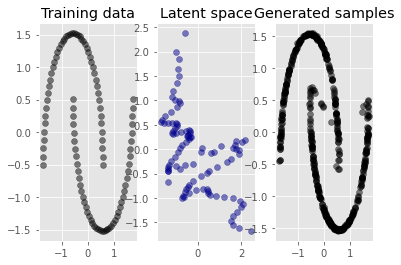

In [30]:
model_rvnp, opt_rvnp, loss_rvnp = train(args, model_rnvp, opt_rnvp, vis=True)

Iter: 0	Logprob: -1560.79	Prior: -1565.12	LogDet: 4.33
Iter: 200	Logprob: -2.90	Prior: -2.72	LogDet: -0.19
Iter: 400	Logprob: -2.67	Prior: -2.82	LogDet: 0.14
Iter: 600	Logprob: -2.58	Prior: -2.80	LogDet: 0.22
Iter: 800	Logprob: -2.42	Prior: -2.74	LogDet: 0.33
Iter: 1000	Logprob: -2.19	Prior: -2.68	LogDet: 0.50
Iter: 1200	Logprob: -1.82	Prior: -2.64	LogDet: 0.82
Iter: 1400	Logprob: -2.11	Prior: -2.76	LogDet: 0.65
Iter: 1600	Logprob: -3.22	Prior: -4.17	LogDet: 0.94
Iter: 1800	Logprob: -2.76	Prior: -3.08	LogDet: 0.32
Iter: 2000	Logprob: -2.65	Prior: -3.15	LogDet: 0.49
Iter: 2200	Logprob: -1.97	Prior: -3.24	LogDet: 1.27
Iter: 2400	Logprob: -2.12	Prior: -2.80	LogDet: 0.68
Iter: 2600	Logprob: -1.76	Prior: -2.82	LogDet: 1.06
Iter: 2800	Logprob: -1.78	Prior: -3.14	LogDet: 1.36
Iter: 3000	Logprob: -1.55	Prior: -2.60	LogDet: 1.05
Iter: 3200	Logprob: -1.51	Prior: -2.64	LogDet: 1.13
Iter: 3400	Logprob: -2.14	Prior: -2.74	LogDet: 0.61
Iter: 3600	Logprob: -1.95	Prior: -2.78	LogDet: 0.83
Iter: 3800	L

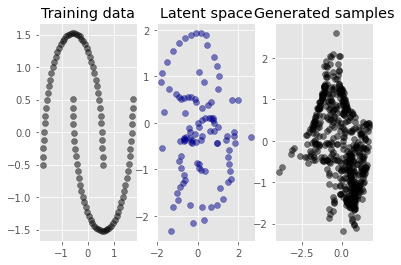

In [31]:
args.iterations=5000
model_glow, opt_glow, loss_glow = train(args, model_glow, opt_glow, vis=True)

# Appendix

## Normalizing Flow 

<img src="imgs/flow1.png" width="1000" height="500">
<img src="imgs/flow2.png" width="1000" height="500">

## python "eval" function

```python
eval(expression:str)
```

- string의 expression(ex : "1+2")를 받아, 이를 그대로 python으로 실행하는 함수

In [32]:
# ref : https://blockdmask.tistory.com/437

eval("1+2")

3

In [33]:
eval("[x*2 for x in range(5)]")

[0, 2, 4, 6, 8]

## Planar

- reference : Stefano Ermon, Yang Song(stanford univ, lecture 7)
    - https://deepgenerativemodels.github.io/assets/slides/cs236_lecture7.pdf

<img src="imgs/planar_t.png" width="1000" height="500">

**make moons**

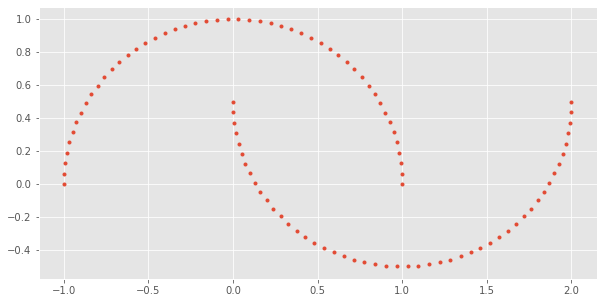

In [34]:
from sklearn.datasets import make_moons

data, _ = make_moons(n_samples=100)

plt.figure(figsize=(10,5))
plt.plot(data[:,0], data[:,1], '.')
plt.show()

**Planar transformation**

- residual : nonlinearity
    - u에 의해 원 데이터에 더해지는 nonlinearity값에 변화가 생김


- w, b 고정
- u만 변화시키며 transformation결과 확인

<img src="imgs/planar.png" width="250" height="50">

In [35]:
scal = torch.log(1+torch.exp(self.w @ self.u)) - self.w @ self.u - 1
u = self.u + scal * self.w / torch.norm(self.w) ** 2
lin = torch.unsqueeze(x @ self.w, 1) + self.b
z = x + u * self.h(lin)
phi = functional_derivatives[self.h](lin) * self.w
log_det = torch.log(torch.abs(1 + phi @ u) + 1e-4)
return z, log_det

NameError: name 'self' is not defined

In [ ]:
from matplotlib import collections  as mc

def linear(w, x, b):
    '''
    linear transformation : w.T@z + b
    
    in : 2-dim 
    out : 1-dim
    '''
    return x@w + b

def planar(u):
    '''
    planar transformation : data + u * tanh(linear)
    
    in : 2-dim
    out : 2-dim
    '''
    return data + u*np.tanh(linear(w,data,b)[:, np.newaxis])


data, _ = make_moons(n_samples=100)
w, b = np.ones(2,)*2., np.zeros(1,)
fig, axes = plt.subplots(5, 2, figsize=(20, 20))

for i, v in enumerate(np.linspace(0.2, 2., 10)):
    u = np.ones((2,)) * v

    transformed = planar(u)

    axes[i//2, i%2].plot(data[:, 0], data[:, 1], '.', color='blue');
    axes[i//2, i%2].axis('off');
    axes[i//2, i%2].plot(transformed[:, 0], transformed[:, 1], '.', color='red');
    axes[i//2, i%2].set_title('v=%.1f' % v)

    lines = [[data[i], transformed[i]] for i in range(100)]
    lc = mc.LineCollection(lines, colors='black', linewidths=0.5)
    axes[i//2, i%2].add_collection(lc)

**Log determinant of 'Planar flow'**

- reference : Stefano Ermon, Yang Song(stanford univ, lecture 7)
    - https://deepgenerativemodels.github.io/assets/slides/cs236_lecture7.pdf

- objective function of NF
<img src="imgs/objec.png" width="1000" height="500">

- Log determinant of 'Planar flow'
<img src="imgs/planar_logdet.png" width="1000" height="500">

## Affine coupling layer

<img src="imgs/affine.png" width="1000" height="500">

## Glow

- structure

<img src="imgs/glow_structure.png" width="1000" height="500">

- 1x1 conv

<img src="imgs/1x1_2.png" width="1000" height="500">
<img src="imgs/1x1_1.png" width="1000" height="500">
<img src="imgs/1x1_3.png" width="1000" height="500">

       

- Act norm

<img src="imgs/actnorm.png" width="1000" height="500">

- Log determinant of '1x1 conv' and 'Act norm'

<img src="imgs/log_det_1x1.png" width="1000" height="500">